In [1]:
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import matplotlib as mpl
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

Connecting austin@datajoint.internationalbrainlab.org:3306


In [2]:
from psychofit import psychofit as psy

In [3]:
from analyses.behavior_plots import fix_date_axis, plot_perf_heatmap, plot_psychometric, plot_chronometric

In [4]:
ibl17 = (subject.Subject() & 'subject_nickname = "IBL_17"').fetch1()

In [5]:
def dj_get_water(mouse):
    w = (action.WaterAdministration() & mouse).fetch(as_dict=True)
    w = pd.DataFrame(w)
    w.rename(columns={'administration_time':'date_time'}, inplace=True)
    w['date_time'] = pd.to_datetime(w.date_time)
    w.sort_values('date_time', inplace=True)
    w.reset_index(drop=True, inplace=True)
    w['date'] = w['date_time'].dt.floor('D')
    w['days'] = w.date - w.date[0]
    w['days'] = w.days.dt.days
    w = w.set_index('date')
    w.index = pd.to_datetime(w.index)
    wa_unstacked = w.pivot_table(index='date', 
        columns='watertype_name', values='water_administered', aggfunc='sum').reset_index()
    wa_unstacked['date'] = pd.to_datetime(wa_unstacked.date)
    wa_unstacked.set_index('date', inplace=True)
    return wa_unstacked, w

In [6]:
def dj_get_behavior(mouse):
    b = behavior.TrialSet.Trial & mouse
    behav = pd.DataFrame(b.fetch(order_by='session_start_time, trial_id'))
    behav['start_time'] = behav['session_start_time']
    behav['trial'] = behav['trial_id'] - 1
    behav['session_start_time'] = pd.to_datetime(behav.session_start_time)
    behav['date']       = behav['session_start_time'].dt.floor("D")
    behav['days']       = behav.date - behav.date[0]
    behav['days']       = behav.days.dt.days
    behav['signedContrast'] = (behav['trial_stim_contrast_left'] - behav['trial_stim_contrast_right']) * 100
    behav['signedContrast'] = behav.signedContrast.astype(int)
    val_map = {'CCW': -1, 'No Go': 0, 'CW': 1}
    behav['choice'] = behav['trial_choice'].map(val_map)
    behav['correct']   = np.where(np.sign(behav['signedContrast']) == behav['choice'], 1, 0)
    behav.loc[behav['signedContrast'] == 0, 'correct'] = np.NaN
    behav['choice2'] = behav.choice.replace([-1, 0, 1], [0, np.nan, 1]) # code as 0, 100 for percentages
    behav['correct_easy'] = behav.correct
    behav.loc[np.abs(behav['signedContrast']) < 50, 'correct_easy'] = np.NaN
    behav.rename(columns={'trial_stim_prob_left':'probabilityLeft'}, inplace=True)
    behav['rt'] = behav['trial_response_time'] - behav['trial_stim_on_time']
    behav['included'] = behav['trial_included']
    return behav

In [7]:
def fit_psychfunc(df):

    # reshape data
    choicedat = df.groupby('signedContrast').agg({'trial_id':'max', 'choice2':'mean'}).reset_index()
    # print(choicedat)

    # if size(np.abs(df['signedContrast'])) > 6:
    pars, L = psy.mle_fit_psycho(choicedat.values.transpose(), P_model='erf_psycho_2gammas', parstart=np.array([choicedat['signedContrast'].mean(), 20., 0.05, 0.05]), parmin=np.array([choicedat['signedContrast'].min(), 0., 0., 0.]), parmax=np.array([choicedat['signedContrast'].max(), 100., 1, 1]))

    df2 = {'bias':pars[0],'threshold':pars[1], 'lapselow':pars[2], 'lapsehigh':pars[3]}
    return pd.DataFrame(df2, index=[0])

## Weight over time

In [8]:
wei = {}
wei['date_time'], wei['weight'] = (action.Weighing() & ibl17).fetch('weighing_time', 'weight', order_by='weighing_time')

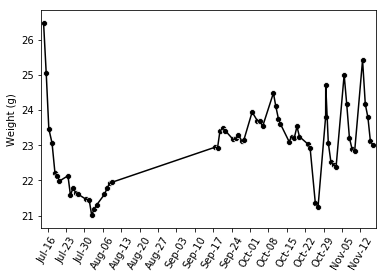

In [9]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="date_time", y="weight", color="black", markers=True, data=wei, ax=ax)
sns.scatterplot(x="date_time", y="weight", color="black", data=wei, ax=ax)
ax.set(xlabel='', ylabel="Weight (g)", 
xlim=[wei['date_time'].min()-timedelta(days=1), wei['date_time'].max()+timedelta(days=1)])
fix_date_axis(ax)

## Water intake

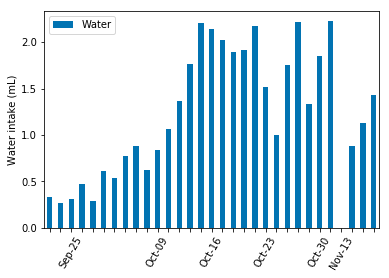

In [10]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.set_palette("colorblind") # palette for water
wa_unstacked, wa = dj_get_water(ibl17)
wa_unstacked.loc[:,['Water']].plot.bar(stacked=True, ax=ax)
l = ax.legend()
l.set_title('')
ax.set(ylabel="Water intake (mL)", xlabel='')

# fix dates, known to be an issue in pandas/matplotlib
ax.set_xticklabels([dt.strftime('%b-%d') if dt.weekday() is 1 else "" for dt in wa_unstacked.index.to_pydatetime()])
for item in ax.get_xticklabels():
    item.set_rotation(60)

## Performance on easy trials

In [11]:
behav = dj_get_behavior(ibl17)
correct_easy = behav.groupby(['session_start_time'])['correct_easy'].mean().reset_index()
trialcounts = behav.groupby(['session_start_time'])['trial_id'].max().reset_index()

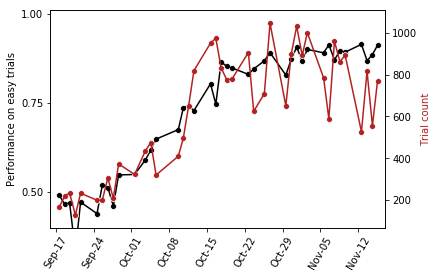

In [12]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="session_start_time", y="correct_easy", markers=True, color="black", data=correct_easy, ax=ax)
sns.scatterplot(x="session_start_time", y="correct_easy", color="black", data=correct_easy, ax=ax)
ax.set(xlabel='', ylabel="Performance on easy trials", 
    xlim=[behav.date.min()-timedelta(days=1), behav.date.max()+timedelta(days=2)],
    yticks=[0.5, 0.75, 1], ylim=[0.4, 1.01])
ax.yaxis.label.set_color("black")
righty = ax.twinx()
sns.lineplot(x="session_start_time", y="trial_id", markers=True, color="firebrick", data=trialcounts, ax=righty)
sns.scatterplot(x="session_start_time", y="trial_id", color="firebrick", data=trialcounts, ax=righty)
righty.yaxis.label.set_color("firebrick")
righty.grid(False)
fix_date_axis(righty)
fix_date_axis(ax)
righty.set(xlabel='', ylabel="Trial count", 
xlim=[behav.date.min()-timedelta(days=1), behav.date.max()+timedelta(days=2)])
fix_date_axis(ax)

## Contrast/choice heatmap

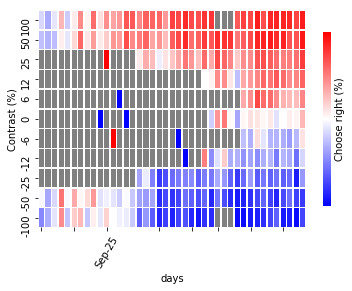

In [13]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plot_perf_heatmap(behav, ax=ax)
ax.set_xticklabels([dt.strftime('%b-%d') if dt.weekday() is 1 else "" for dt in wa_unstacked.index.to_pydatetime()])
for item in ax.get_xticklabels():
    item.set_rotation(60)

## Psychometric function fits over time

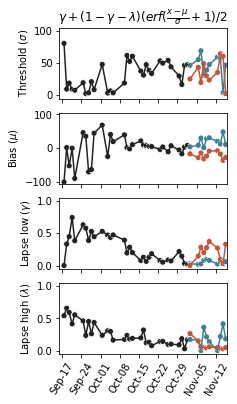

In [14]:
fig, axes = plt.subplots(ncols=1, nrows=4, constrained_layout=False, figsize=(3, 6))
pars = behav.groupby(['session_start_time', 'probabilityLeft']).apply(fit_psychfunc).reset_index()
parsdict = {'threshold': r'Threshold $(\sigma)$', 'bias': r'Bias $(\mu)$', 
    'lapselow': r'Lapse low $(\gamma)$', 'lapsehigh': r'Lapse high $(\lambda)$'}
ylims = [[-5, 105], [-105, 105], [-0.05, 1.05], [-0.05, 1.05]]

# pick a good-looking diverging colormap with black in the middle
cmap = sns.diverging_palette(220, 20, n=len(behav['probabilityLeft'].unique()), center="dark")
if len(behav['probabilityLeft'].unique()) == 1:
    cmap = "gist_gray"
sns.set_palette(cmap)

for pidx, (var, labelname) in enumerate(parsdict.items()):
    ax = axes[pidx]
    sns.lineplot(x="session_start_time", y=var, hue="probabilityLeft", palette=cmap, data=pars, legend=None, ax=ax)
    sns.scatterplot(x="session_start_time", y=var, hue="probabilityLeft", palette=cmap, data=pars, legend=None, ax=ax)
    ax.set(xlabel='', ylabel=labelname, ylim=ylims[pidx], xlim=[behav.date.min()-timedelta(days=1), behav.date.max()+timedelta(days=1)])

    fix_date_axis(ax)
    if pidx == 0:
        ax.set(title=r'$\gamma + (1 -\gamma-\lambda)  (erf(\frac{x-\mu}{\sigma} + 1)/2$')
    if pidx < 3:
        ax.set(xticklabels=[])

## Last three sessions

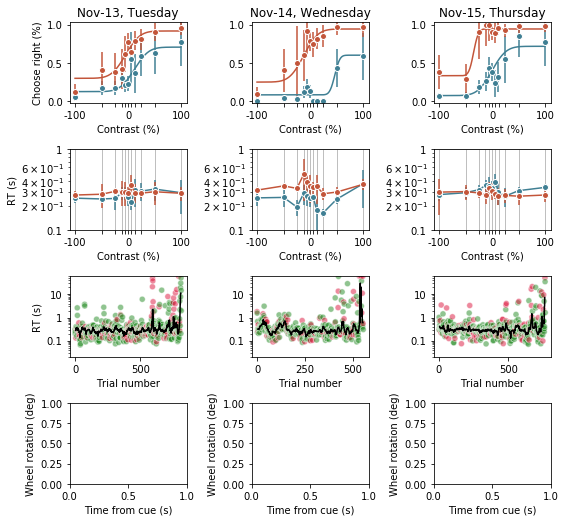

In [15]:
fig, axes = plt.subplots(ncols=3, nrows=4, constrained_layout=False, figsize=(8, 8))
didx = 0
sorteddays = behav['days'].sort_values(ascending=True).unique()
for day in sorteddays[-3:]:

    dat = behav.loc[behav['days'] == day, :]

    # PSYCHOMETRIC FUNCTION
    ax = axes[0, didx]
    cmap = sns.diverging_palette(220, 20, n=len(dat['probabilityLeft'].unique()), center="dark")
    if len(dat['probabilityLeft'].unique()) == 1:
        cmap = [np.array([0,0,0,1])]

    for ix, probLeft in enumerate(dat['probabilityLeft'].sort_values().unique()):
        plot_psychometric(dat.loc[dat['probabilityLeft'] == probLeft, :], ax=ax, color=cmap[ix])

    ax.set(xlabel="Contrast (%)", ylabel="Choose right (%)")
    ax.set(title=pd.to_datetime(dat['start_time'].unique()[0]).strftime('%b-%d, %A'))

    # CHRONOMETRIC FUNCTION
    ax = axes[1, didx]
    for ix, probLeft in enumerate(dat['probabilityLeft'].sort_values().unique()):
        plot_chronometric(dat.loc[dat['probabilityLeft'] == probLeft, :], ax, cmap[ix])
    ax.set(ylim=[0.1,1])
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

    # RTS THROUGHOUT SESSION
    ax = axes[2, didx]
    sns.scatterplot(x='trial', y='rt', hue='correct', 
        palette={1:"forestgreen", 0:"crimson"},
        alpha=.5, data=dat, ax=ax, legend=False)
    sns.lineplot(x='trial', y='rt', color='black', ci=None, 
        data=dat[['trial', 'rt']].rolling(10).median(), ax=ax) 
    ax.set(xlabel="Trial number", ylabel="RT (s)", ylim=[0.02, 60])
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

    # WHEEL ANALYSIS
    # thisdate = dat.loc[dat.index[0], 'date'].strftime('%Y-%m-%d')
    # eid = one.search(subjects=mouse, date_range=[thisdate, thisdate])
    # t, wheelpos, wheelvel = one.load(eid[0], 
    # 	dataset_types=['_ibl_wheel.timestamps', '_ibl_wheel.position', '_ibl_wheel.velocity'])
    # wheeltimes = np.interp(np.arange(0,len(wheelpos)), t[:,0], t[:,1])
    #    #times = np.interp(np.arange(0,len(wheelPos)), t[:,0], t[:,1])
    # wheel = pd.DataFrame.from_dict({'position':wheelpos, 'velocity':wheelvel, 'times':wheeltimes})

    # ax = axes[3, didx]
    # sns.lineplot(x=wheeltimes, y=wheelpos, ax=ax)
    ax = axes[3, didx]
    ax.set(xlabel='Time from cue (s)', ylabel='Wheel rotation (deg)')
    
    didx += 1

for i in range(3):
    axes[i,1].set(ylabel='')
    axes[i,2].set(ylabel='')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])